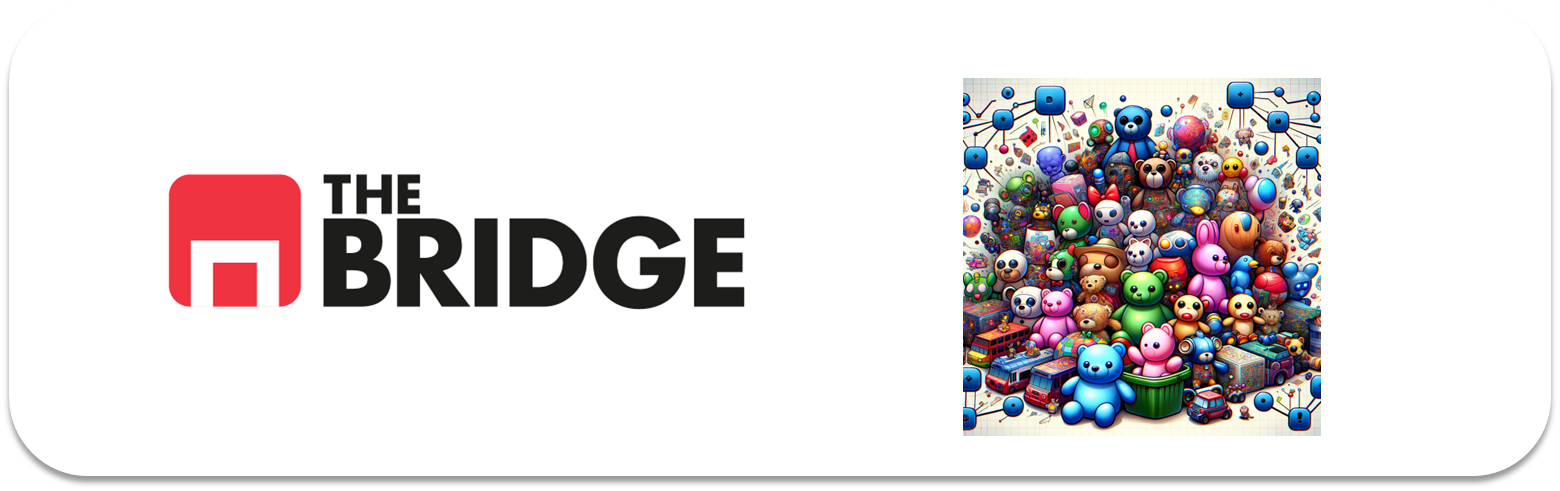

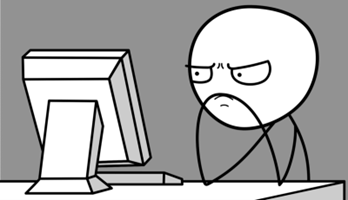

## PRACTICA OBLIGATORIA: DBSCAN y CLUSTERING JERARQUICO

* La práctica obligatoria de esta unidad consiste en un ejercicio de modelado no supervisado aplicado a clustering jerárquico y no jerárquico. Descarga este notebook en tu ordenador y trabaja en local. Ten en cuenta que tendrás que descar los directorios de imágenes y datos adicionales, si los hubiera.
* Recuerda que debes subirla a tu repositorio personal antes de la sesión en vivo para que puntúe adecuadamente.  
* Recuerda también que no es necesario que esté perfecta, sólo es necesario que se vea el esfuerzo. 
* Esta práctica se resolverá en la sesión en vivo correspondiente y la solución se publicará en el repo del curso. 

### Ejercicio 0

Importa los paquetes y módulos que necesites a lo largo del notebook

In [36]:
import bootcampviztools as bt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import seaborn as sns


from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score


#ignore warnings
import warnings
warnings.filterwarnings('ignore')

### Parte I. Modelado

#### Descripción del problema.

En una planta de experimentación con nuevas bebidas energéticas están trabajando con diferentes mezclas de componentes para obtener posibles variedades de su producto estrella "NonstopU". El problema es que la fabricación de cada "prototipo" conlleva demasiado tiempo y las pruebas de sabores y de propiedades "non-stop" antisueño y antifatiga son costosas.  

En ese sentido quieren construir algún sistema de segmentación previa de mezclas sin probarlas solo indicando las cantidades de cada componente de la bebida. Tienen datos pero desgraciadamente de mezclas anteriores con diferentes medidas pero que por temas presupuestarios y de prioridad no se hicieron test con usuarios y potenciales clientes, es decir no tienen un target de capacidad antifatiga o de preferncia del usuario que puedas servirles para construir un clasificador clásico como han hecho otras veces.  

Han acudido a vosotros con la necesida de encontrar ese segmentador de posibles bebidas y con los datos de las mezclas no probadas anteriores por ver si vostros podéis ayudarles a encontrar algún tipo de segmentación que luego ello se encargarían de interpretar. No es requisito obligatorio pero les gustaría también poder establecer algún tipo de relación entre las segmentaciones (tipo cuales segmentos se "parecerían" más entre sí)

NOTA ORIENTATIVA: Los químicos no esperan que haya menos de 3 segmentos ni más de 5.  
NOTA OPERATIVA: El dataset con los datos que nos han dado los químicos está en "./data/empowering_drinks.csv"

**Se pide**: Construir al menos dos algoritmos de clustering (DBSCAN debe ser uno de ellos y el otro debería estar claro cual deberíamos usar dado el enunciado). Compararlos brevemente aunque sea meramente especulativo (¿Por qué es espculativo?)

**Se recomienda**: Visualizar las features dos a dos para escoger las mejores, no necesariamente hay que usar todas, ni tampoco quedarse en dos. Probar diferentes hiperparámetros en función de la nota orientativa y explicar porqué se han escogido los que finalmente se hayan escogido. 

Recuerda que el proceso es similar a lo que vimos en el otro tipo de aprendizaje:
1. Entender el problema
2. Cargar datos, visualizar.
3. MiniEDA: Selección de features
4. Tratamiento de Features.
5. Selección de modelos, selección de hiperparámetros
6. Entrenamiento, visualización de resultados.
7. Discusión de los mismos


## Cargar datos y visualizar

In [4]:
df = pd.read_csv("./data/empowering_drinks.csv", sep='|')

In [5]:
df.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.518613,0.232053,1.034819,1.013009,0.251717
1,0.246290,-0.827996,0.733629,0.965242,-0.293321
2,0.196879,1.109334,1.215533,1.395148,0.269020
3,1.691550,0.487926,1.466525,2.334574,1.186068
4,0.295700,1.840403,0.663351,-0.037874,-0.319276


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 153 entries, 0 to 152
Data columns (total 5 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Azúcares               153 non-null    float64
 1   Vitamínas del grupo B  153 non-null    float64
 2   Cafeína                153 non-null    float64
 3   Ácido Cítrico          153 non-null    float64
 4   Taurina                153 non-null    float64
dtypes: float64(5)
memory usage: 6.1 KB


In [7]:
df.describe()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
count,153.000000,153.000000,153.000000,153.000000,153.000000
mean,0.019231,0.037273,0.041057,0.080022,-0.044088
std,1.026182,0.995984,1.040928,1.009450,0.934399
min,-2.434235,-3.679162,-1.695971,-1.493188,-1.634288
25%,-0.816038,-0.499016,-1.043392,-0.738463,-0.799428
50%,0.061000,-0.023821,0.211566,-0.165254,-0.154899
75%,0.876275,0.707247,0.894264,0.917474,0.493956
max,2.259772,3.156325,3.062832,2.971473,2.431870


*DATOS LIMPIOS --> No hay nulos y todas las columnas son numéricas y se encuentran más o menos en rangos parecidos*

## MiniEDA

In [10]:
features = df.columns.to_list()
features

['Azúcares', 'Vitamínas del grupo B', 'Cafeína', 'Ácido Cítrico', 'Taurina']

array([[<Axes: title={'center': 'Azúcares'}>,
        <Axes: title={'center': 'Vitamínas del grupo B'}>],
       [<Axes: title={'center': 'Cafeína'}>,
        <Axes: title={'center': 'Ácido Cítrico'}>],
       [<Axes: title={'center': 'Taurina'}>, <Axes: >]], dtype=object)

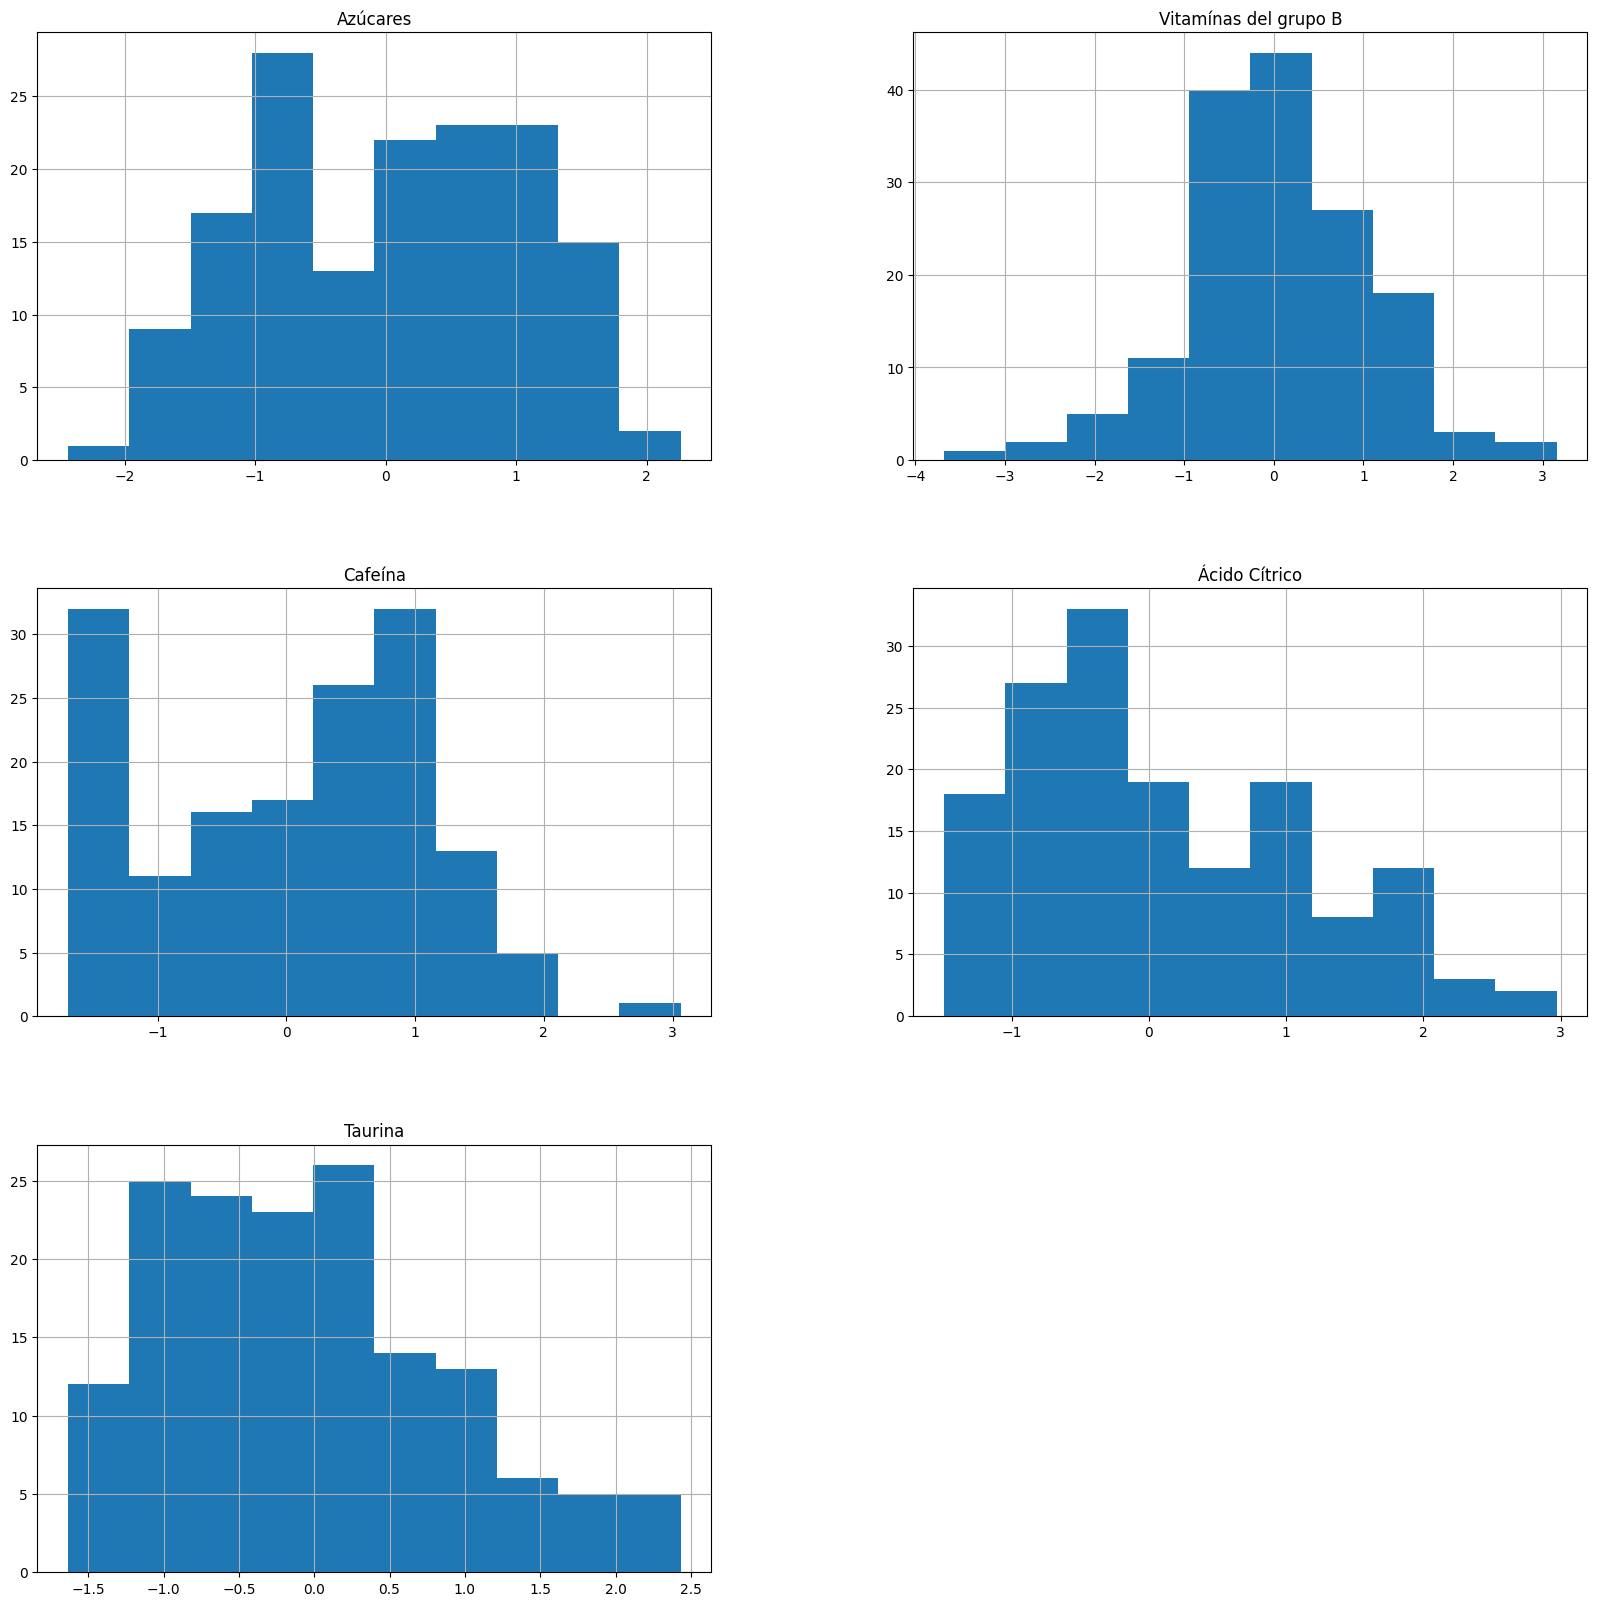

In [8]:
df.hist(figsize=(20,20))

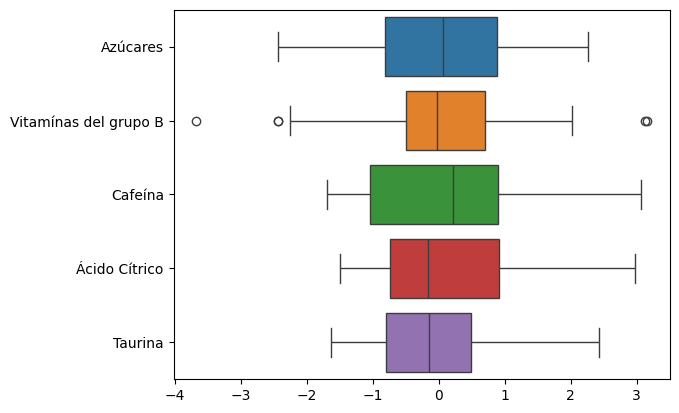

In [11]:
sns.boxplot(df[features], orient='h');

*No hay muchos outliers. Solo se ve algunos en en la features 'Vitaminas del grupo B'*

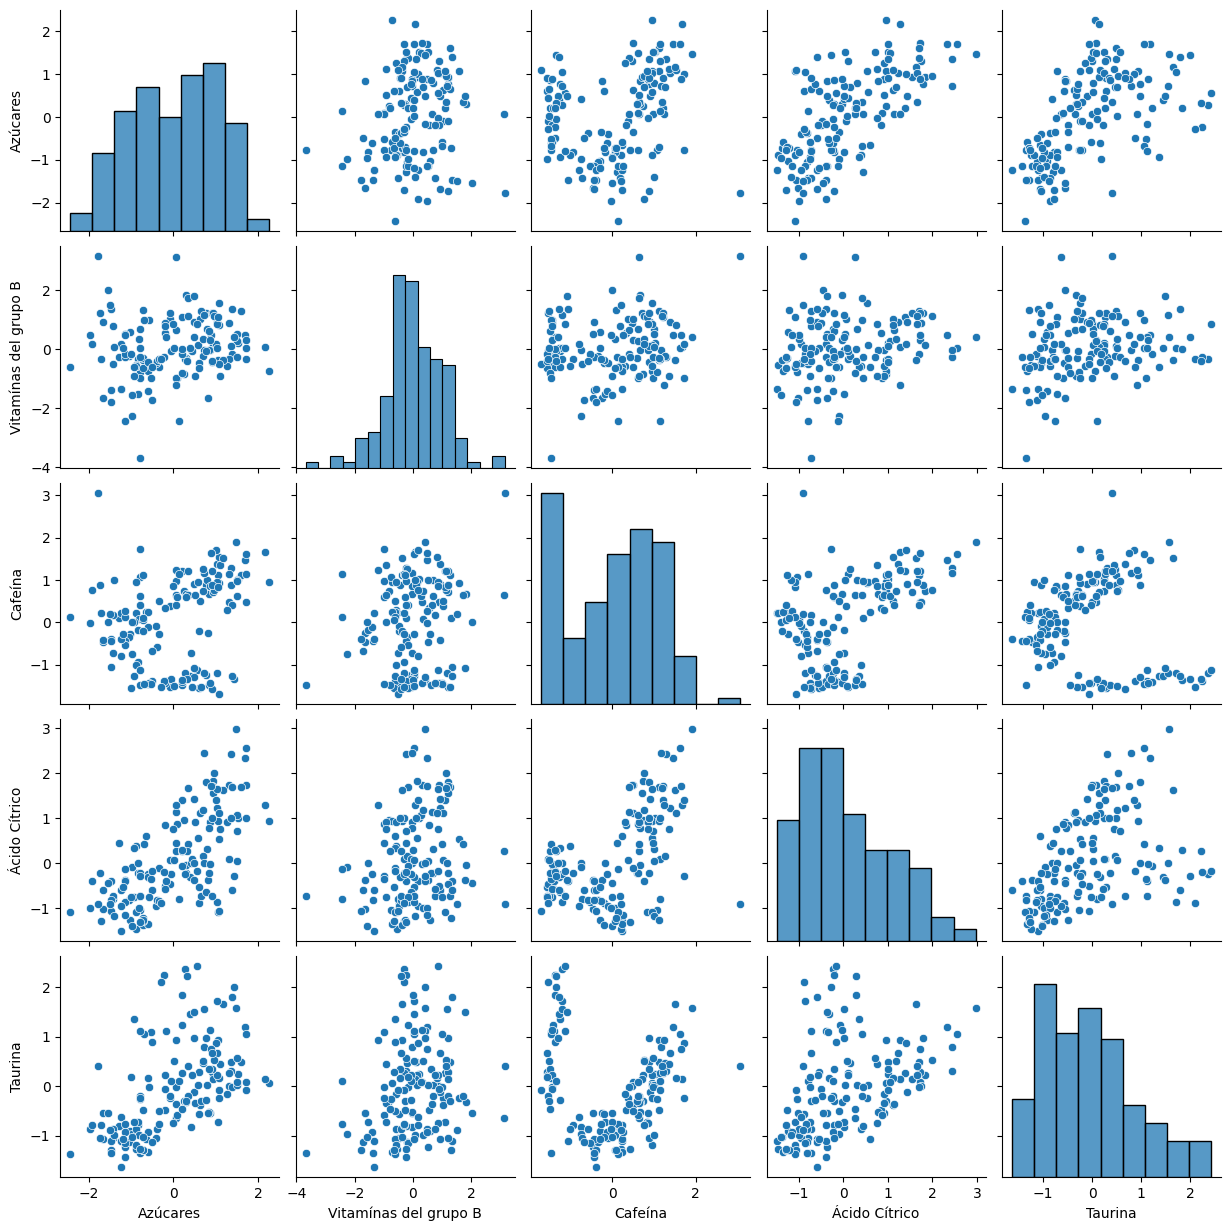

In [12]:
sns.pairplot(df[features])

*A primera vista vemos algunas agrupaciones en los gráficos de dispersión. Especialmente claras son las agrupaciones entre cafeína y taurina o ácido cítrico; y taurina y azúcares* 

## Tratamiento de Features
*No las escalaremos porque tienen todas una escala similar, y además tampoco vemos ninguna de tipo long-tail claramente*

## Selección de modelos e hiperparámetros

### DBSCAN

In [13]:
outlier_percent = []

for eps in np.linspace(0.001,3,50): # Genera 50 valores equidistantes entre 0.001 y 3
    
    # Creamos el modelo
    dbscan = DBSCAN(eps=eps,min_samples=5*df.shape[1]) # min_samples dos veces el ´numero de features -> 2 por dimensión del hiperespacio en el que representamos el conjunto de puntos... No le des muchas vueltas es un número muy orientativo. Pero piensa que si fuera un recta querrías 2 valores, un plano 4, un cubo 6...
    dbscan.fit(df)
   
     
    # Registramos el porcentaje de anomalías (recuerda que se etiquetan como -1)
    perc_outliers = 100 * np.sum(dbscan.labels_ == -1) / len(dbscan.labels_)
    
    outlier_percent.append(perc_outliers)

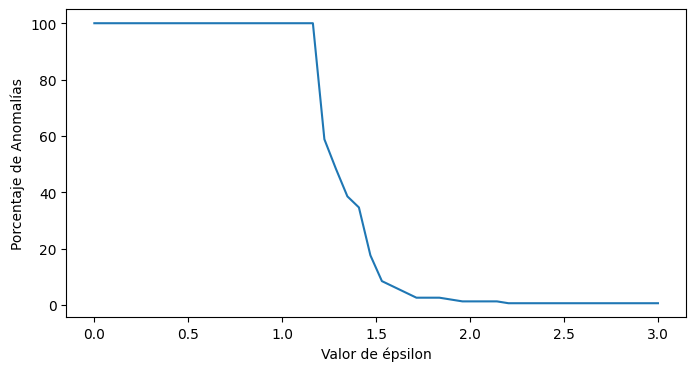

In [14]:
#Vamos a pintar ahora el porcentaje de anomalías vs el valor de eps probado
plt.figure(figsize = (8,4), dpi = 100)
sns.lineplot(x=np.linspace(0.001,3,50),y=outlier_percent)
plt.ylabel("Porcentaje de Anomalías")
plt.xlabel("Valor de épsilon")
plt.show()

In [15]:
for indice,eps in [(indice,val) for indice,val in enumerate(np.linspace(0.001,3,50)) if 1.3 <= val <= 1.8]:
    print(f"Para {eps}: {outlier_percent[indice]}% de anomalías")

Para 1.3474897959183672: 38.56209150326797% de anomalías
Para 1.4086938775510203: 34.64052287581699% de anomalías
Para 1.4698979591836734: 17.647058823529413% de anomalías
Para 1.5311020408163265: 8.49673202614379% de anomalías
Para 1.5923061224489796: 6.5359477124183005% de anomalías
Para 1.6535102040816325: 4.57516339869281% de anomalías
Para 1.7147142857142856: 2.6143790849673203% de anomalías
Para 1.7759183673469388: 2.6143790849673203% de anomalías


*nos quedamos con 1.5*

In [28]:
#fit DBSCAN with eps = 2
#dbscan = DBSCAN(eps=2, min_samples= 5*len(df_wholesome_customers.columns.to_list()))
dbscan = DBSCAN(eps = 1.5, min_samples= 5)
dbscan.fit(df)

DBSCAN(eps=1.5)

In [29]:
dbscan.min_samples

5

In [30]:
df['Labels'] = dbscan.labels_
df['Labels'].value_counts()

Labels
 0    149
-1      4
Name: count, dtype: int64

*Encontramos 2 agrupaciones --> cabe darle una vuelta porque los químicos ya esperaban entre 3 y 5*

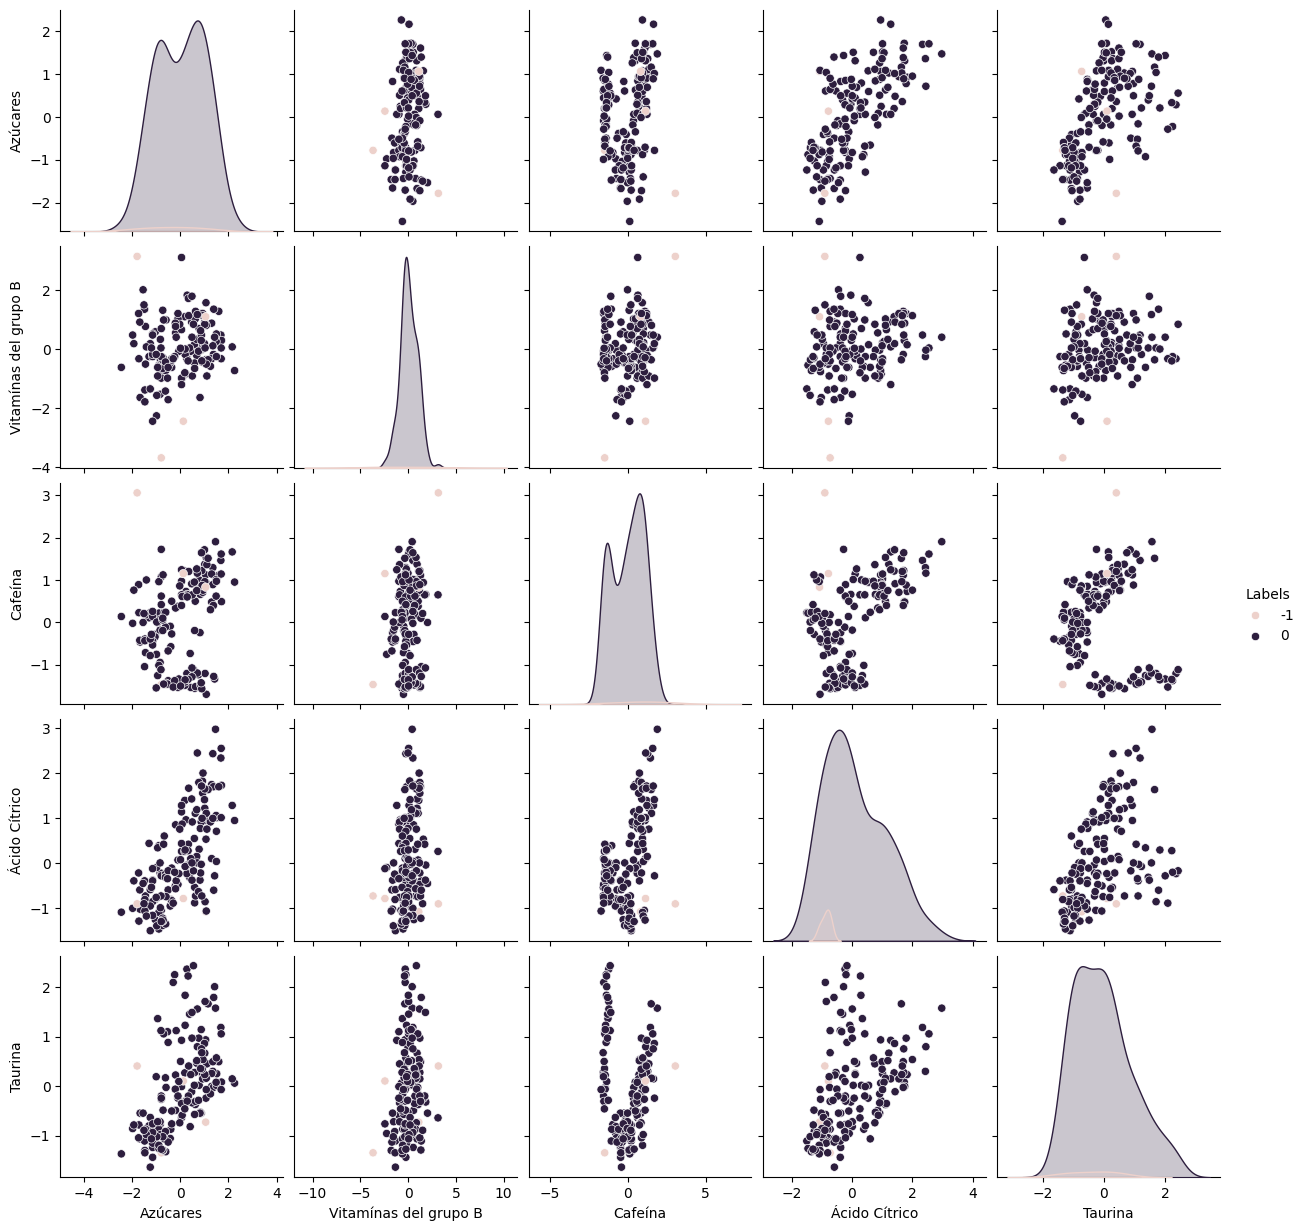

In [31]:
sns.pairplot(df, hue='Labels')

*No parece una buena agrupación*
*Pruebo un nuevo modelo escalando antes los datos*

In [32]:
# Escalado de datos
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)


In [34]:
dbscan = DBSCAN(eps=1.5, min_samples=5)  
Labels_1 = dbscan.fit_predict(scaled_data)

In [35]:
df['Labels_1'] = Labels_1
df['Labels_1'].value_counts()

Labels_1
 0    149
-1      4
Name: count, dtype: int64

* No tiene mucha mejor pinta --> Voy a intentar hacer un nuevo ajuste de hiperparámetros:*

In [38]:
from sklearn.metrics import silhouette_score

best_score = -1
best_eps = None
best_min_samples = None
best_clusters = None

# Realizar ajuste de hiperparámetros
for eps in [0.5, 1.0, 1.5, 2.0]:
    for min_samples in [2, 3, 4]:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(scaled_data)
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)  # Ignorar los outliers (-1)
        if n_clusters > 1:  # Solo calcular Silhouette Score si hay más de un cluster
            silhouette = silhouette_score(scaled_data, clusters)
            print(f"Para eps={eps}, min_samples={min_samples}: {n_clusters} clusters, Silhouette Score={silhouette}")
            if silhouette > best_score:
                best_score = silhouette
                best_eps = eps
                best_min_samples = min_samples
                best_clusters = clusters

# Mostrar los mejores hiperparámetros y el score Silhouette correspondiente
print(f"Mejor eps: {best_eps}, Mejor min_samples: {best_min_samples}")
print(f"Silhouette Score: {best_score}")

# Mostrar las asignaciones de cluster resultantes con los mejores hiperparámetros
print("Asignaciones de cluster con los mejores hiperparámetros:")
for i, cluster in enumerate(best_clusters):
    print(f"Muestra {i}: Cluster {cluster}")


Para eps=0.5, min_samples=2: 19 clusters, Silhouette Score=-0.24297689242058118
Para eps=0.5, min_samples=3: 8 clusters, Silhouette Score=-0.31384064824122226
Para eps=0.5, min_samples=4: 3 clusters, Silhouette Score=-0.15367174437659703
Para eps=1.0, min_samples=2: 6 clusters, Silhouette Score=0.07966510222583853
Para eps=1.0, min_samples=3: 4 clusters, Silhouette Score=0.2913865488889222
Para eps=1.0, min_samples=4: 4 clusters, Silhouette Score=0.2456374871610705
Mejor eps: 1.0, Mejor min_samples: 3
Silhouette Score: 0.2913865488889222
Asignaciones de cluster con los mejores hiperparámetros:
Muestra 0: Cluster 0
Muestra 1: Cluster 0
Muestra 2: Cluster 0
Muestra 3: Cluster 0
Muestra 4: Cluster 0
Muestra 5: Cluster 0
Muestra 6: Cluster 0
Muestra 7: Cluster 0
Muestra 8: Cluster 0
Muestra 9: Cluster 0
Muestra 10: Cluster 0
Muestra 11: Cluster 0
Muestra 12: Cluster 0
Muestra 13: Cluster 0
Muestra 14: Cluster 0
Muestra 15: Cluster 0
Muestra 16: Cluster 0
Muestra 17: Cluster 0
Muestra 18: C

In [40]:
dbscan = DBSCAN(eps=1, min_samples=3)  
Labels_2 = dbscan.fit_predict(scaled_data)

In [41]:
df['Labels_2'] = Labels_2
df['Labels_2'].value_counts()

Labels_2
 0    54
 1    46
 2    31
-1    19
 3     3
Name: count, dtype: int64

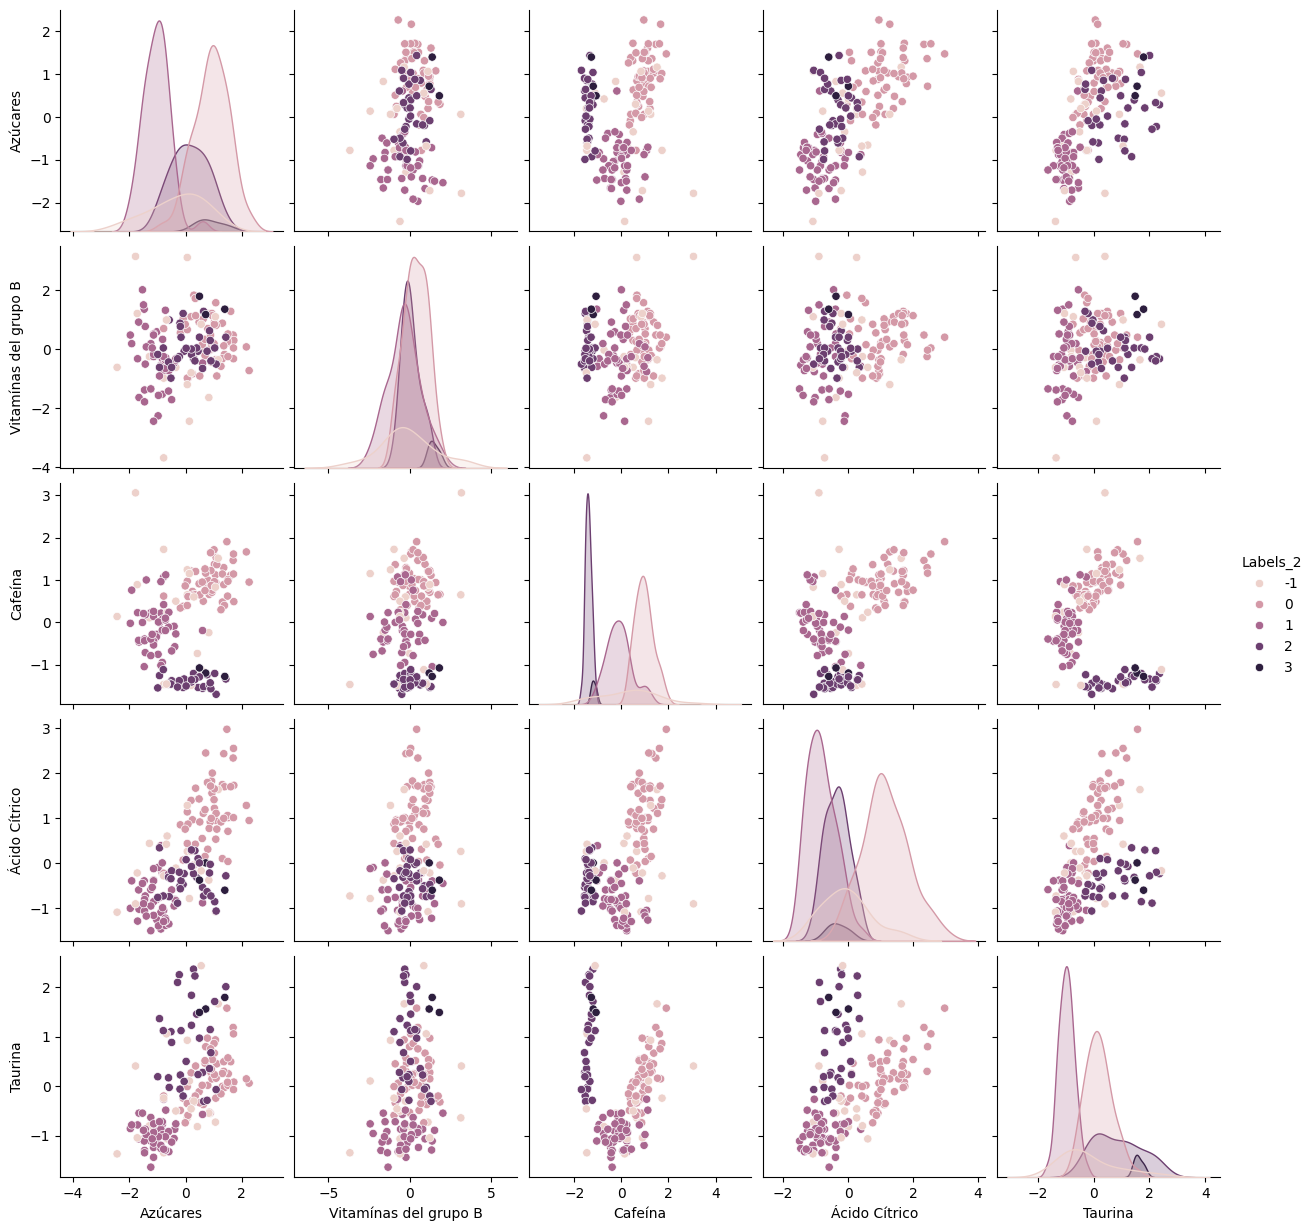

In [44]:
sns.pairplot(df.drop(columns=['Labels', 'Labels_1']), hue='Labels_2')

*Parece una agrupación con algo más de sentido que las anteriores así a simple vista*

### CLUSTERING JERÁRQUICO

In [60]:
link_method = linkage(df[features], method = 'average')

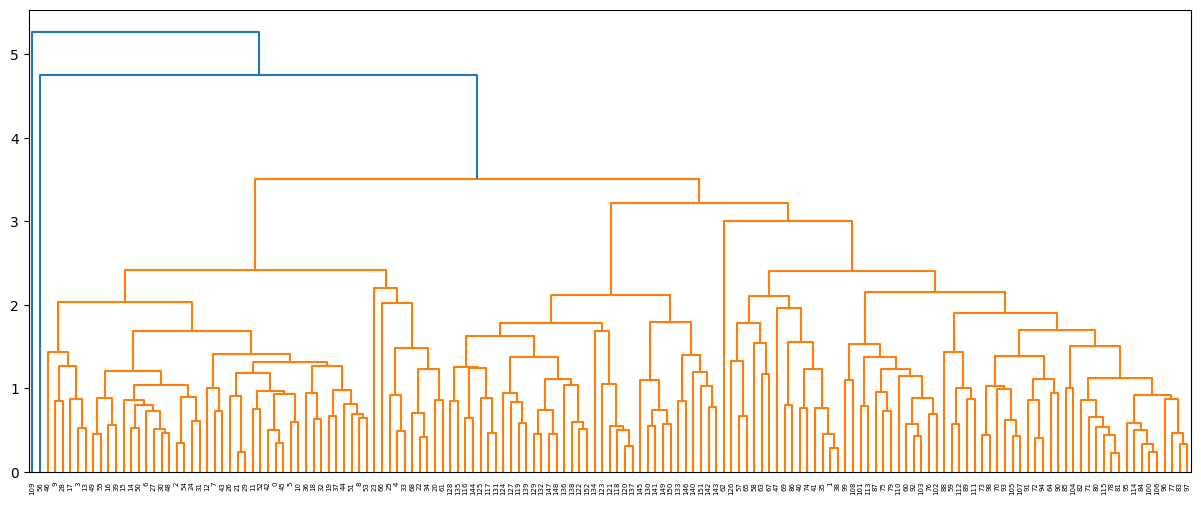

In [50]:
plt.figure(figsize =(15,6))
dend = dendrogram(link_method)

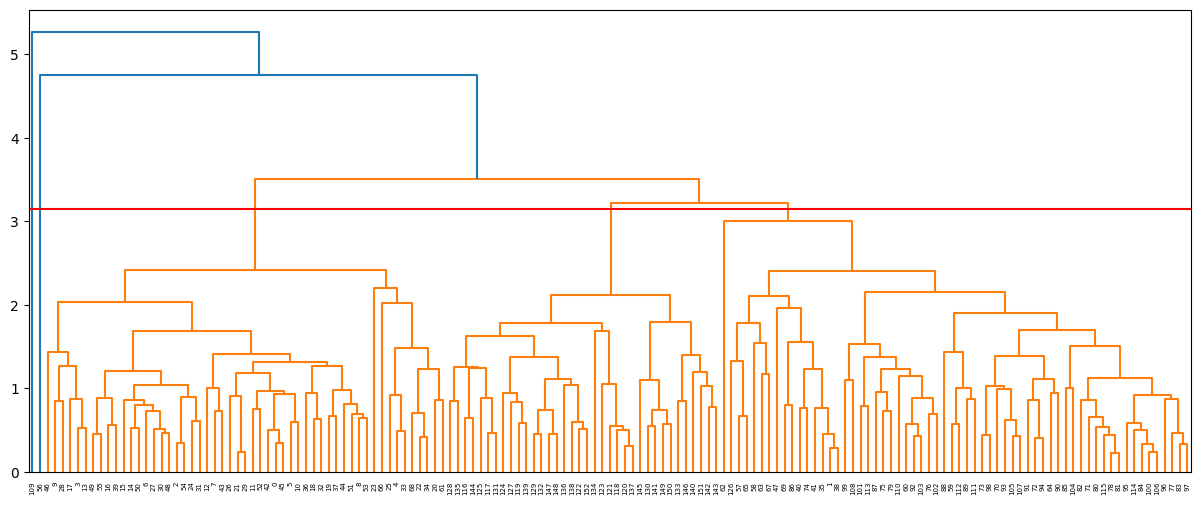

In [52]:
plt.figure(figsize =(15,6))
dend = dendrogram(link_method)
plt.axhline(y = 3.15, color = 'r', linestyle = '-')

*Así a simple vista, lo que apetece es contar con 3 clusters y considerar los dos clusters azules como "outliers"*

In [53]:
clustering_model = AgglomerativeClustering(n_clusters=5, metric='euclidean', linkage='average')
clustering_model.fit(df[features])
df['Cluster'] = clustering_model.labels_

In [54]:
df.Cluster.value_counts()

Cluster
0    62
1    53
4    36
2     1
3     1
Name: count, dtype: int64

In [55]:
features_mean_by_cluster = df[features + ["Cluster"]].groupby('Cluster').mean()
features_mean_by_cluster['Freq'] = df['Cluster'].value_counts().sort_index()

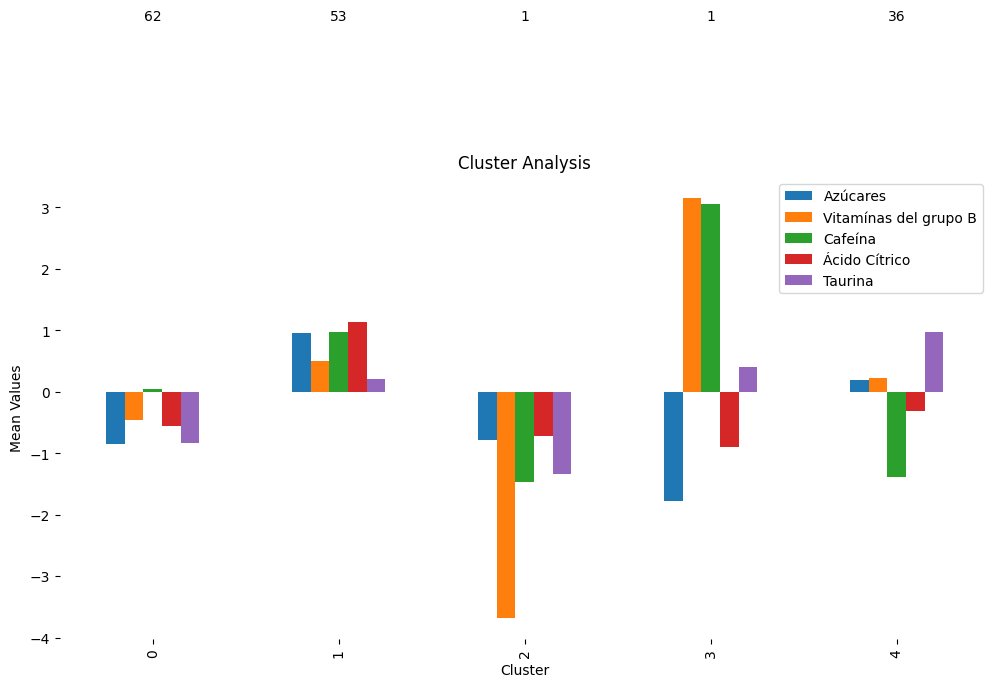

In [56]:
# Perfil de cada cluster
fig, ax = plt.subplots(figsize=(12, 6))
features_mean_by_cluster.iloc[:, :-1].plot(kind='bar', ax=ax)
ax.set_ylabel('Mean Values')
ax.set_title('Cluster Analysis')
for i, v in enumerate(features_mean_by_cluster['Freq']):
    ax.text(i, max(features_mean_by_cluster.iloc[:, :-1].max().max(), 5) + 1, str(v), ha='center', va='bottom')
sns.despine(left=True, bottom=True)
plt.show()

### Parte II. Nuevos experimentos

Los químicos están muy esperanzados con los modelos que les habéis mostrado y os pasan una lista de nuevos experimentos para que los clasifiquéis. Emplea uno de los modelos construidos, el que te resulte más sencillo, para segmentar los nuevos experimentos que puedes encontrar en "./data/new_experiments.csv"

In [47]:
df_II = pd.read_csv("./data/new_experiments.csv", sep='|')

In [48]:
df_II.head()

,Azúcares,Vitamínas del grupo B,Cafeína,Ácido Cítrico,Taurina
0,1.481555,0.305159,1.366128,2.239039,0.731870
1,0.616869,0.890014,0.583034,0.312420,-0.665332
2,-1.680724,0.341713,-0.340615,-0.213021,-0.976782
3,-0.284874,-1.412851,-0.782361,-1.193845,-0.717240
4,-0.927212,0.634140,-1.565455,-0.085641,-0.522583


### Parte III. EXTRA (Voluntario): 6 meses después...

La unidad de experimentación recibió un presupuesto adicional gracias a los modelos que les proporcionastes e hizo pruebas con cliente y obtuvo resultados como para clasificar cada bebida en terminos de "energización" en tres niveles (1, media; 2, media-alta, 3, alta). El resultado de los mismos está en el fichero adecuado en el directorio data y alineado con los experimentos iniciales y al final con los nuevos experimentos de la parte anterior.

Evalua la segmentación de los modelos creados en la primera parte.